# Contextual Subspace for Lithium-ion Battery

This notebook focusses on calculating the contextual subspace hamiltonians for the Li$_2$FeSiO$_4$ material. This can be found in the battery explorer of [Materials Project](https://next-gen.materialsproject.org/batteries/mp-758173_Li?elements=Li%2CFe%2CSi%2CO) (ID: mp-758173, ID of the material: mp-759942).

In [3]:
import json
from tangelo import SecondQuantizedMolecule
from tangelo.toolboxes.molecular_computation.integral_solver_pyscf import mol_to_pyscf, IntegralSolverPySCF
from tangelo.toolboxes.molecular_computation.frozen_orbitals import get_orbitals_excluding_homo_lumo
from time import time
from tangelo.algorithms import VQESolver, CCSDSolver
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from tangelo.toolboxes.operators import count_qubits
import matplotlib.pyplot as plt
import pickle
import os
import numpy as np

## Loading the unit cell

The obtained structure of the unit cell is in fractional coordinates. To start working with the material, we need to convert them into cartesian coordinates. We use the method described [here](https://www.ruppweb.org/Xray/tutorial/Coordinate%20system%20transformation.htm) which involves a matrix multiplication to the fractional coordinates. The function takes the information about the lattice i.e. $a, b, c, \alpha, \beta, \gamma$ and returns the corresponding transformation matrix

In [4]:
def get_fractional_to_cartesian_matrix(a, b, c, alpha, beta, gamma,
                                       angle_in_degrees=True):
    if angle_in_degrees:
        # Convert angles to radians
        alpha = np.radians(alpha)
        beta = np.radians(beta)
        gamma = np.radians(gamma)
        
    lattice_a = np.array([a, 0, 0])
    lattice_b = np.array([b * np.cos(gamma), b * np.sin(gamma), 0])

    n2 = (np.cos(alpha) - np.cos(beta) * np.cos(gamma)) / np.sin(gamma)
    lattice_c = c * np.array([
        np.cos(beta),
        n2,
        np.sqrt(1 - np.cos(alpha)**2 - np.cos(beta)**2 - np.cos(gamma)**2 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)) / np.sin(gamma) 
    ])

    return np.array([lattice_a, lattice_b, lattice_c]).T

We load the structure from .cif file and transform the coordinates to cartesian

In [5]:
f = open('Li2FeSiO4.cif') # Li₂FeSiO₄
data = f.readlines()
data_lines = data[-16:]

def process(line):
    res = line.strip().split()
    atom = res[0][:-1]
    pos = [float(res[3]), float(res[4]), float(res[5])]

    if atom != 'Li':
        atom = atom[:-1]
    return (atom, pos)

res = list(map(process, data_lines))

symbols = [i[0] for i in res]
coords = [i[1] for i in res]

In [6]:
lattice_info = {}
for i in data[3:9]:
    res = i.strip().split()
    lattice_info[res[0].split('_')[-1]] = float(res[1])

lattice_info

{'a': 5.132302,
 'b': 11.037342,
 'c': 6.23237968,
 'alpha': 90.0,
 'beta': 91.30707992,
 'gamma': 90.0}

In [7]:
M = get_fractional_to_cartesian_matrix(*list(lattice_info.values()))
coords = (M @ (np.array(coords).T)).T

In [8]:
geometry = ""
for i, symbol in enumerate(symbols):
    geometry += f"{symbol} {coords[i][0]} {coords[i][1]} {coords[i][2]}\n"

Now that we have the geometry of the material at hand, we can create a second quantized molecule. For this we use [tangelo](https://github.com/goodchemistryco/Tangelo), an open-source python package.

In [9]:
class MyIntegralSolverPySCF(IntegralSolverPySCF):
    def compute_mean_field(self, sqmol):
        molecule = mol_to_pyscf(sqmol, sqmol.basis, sqmol.symmetry, sqmol.ecp)

        sqmol.mean_field = self.scf.RHF(molecule) if not sqmol.uhf else self.scf.UHF(molecule)
        sqmol.mean_field.verbose = 0
        sqmol.mean_field.conv_tol = 1e-5
        
        self.chkfile = 'mf_chkfile'
        sqmol.mean_field.chkfile = self.chkfile
        chkfile_found=True

        # Force broken symmetry for uhf calculation when spin is 0 as shown in
        # https://github.com/sunqm/pyscf/blob/master/examples/scf/32-break_spin_symm.py
        if sqmol.uhf and sqmol.spin == 0 and not chkfile_found:
            dm_alpha, dm_beta = sqmol.mean_field.get_init_guess()
            dm_beta[:1, :] = 0
            dm = (dm_alpha, dm_beta)
            sqmol.mean_field.kernel(dm)
        else:
            sqmol.mean_field.init_guess = "chkfile" if chkfile_found else "minao"
            sqmol.mean_field.kernel()

        sqmol.mean_field.analyze()
        if not sqmol.mean_field.converged:
            raise ValueError("Hartree-Fock calculation did not converge")

        if sqmol.symmetry:
            self.assign_mo_coeff_symmetries(sqmol)
        else:
            sqmol.mo_symm_ids = None
            sqmol.mo_symm_labels = None

        sqmol.mf_energy = sqmol.mean_field.e_tot
        sqmol.mo_energies = sqmol.mean_field.mo_energy
        sqmol.mo_occ = sqmol.mean_field.mo_occ

        sqmol.n_mos = molecule.nao_nr()
        sqmol.n_sos = 2*sqmol.n_mos

        self.mo_coeff = sqmol.mean_field.mo_coeff


class MySQMol(SecondQuantizedMolecule):    
    def __post_init__(self):
        self.solver = MyIntegralSolverPySCF()
        self.solver.set_physical_data(self)
        self.solver.compute_mean_field(self)
        self.freeze_mos(self.frozen_orbitals)

In [10]:
%%time
mol = MySQMol(geometry, q=0, spin=0, basis="sto3g", frozen_orbitals="frozen_core")

CPU times: user 15.6 s, sys: 5.04 s, total: 20.6 s
Wall time: 1.86 s


In [11]:
print(f"{mol.n_active_mos} active molecular orbitals")
print(f"{mol.n_active_electrons} active electrons")

92 active molecular orbitals
112 active electrons


## Active space reduction

Since the number of orbitals are 92, it would require 184 qubits quantum circuit and also the depth of the circuit will be high. We perform active space selection by selecting orbitals near HOMO-LUMO levels. We define the active space from HOMO-3 to LUMO+3

In [12]:
# Selecting HOMO-3 to LUMO+3 orbitals.
n = 3
frozen_orbitals = get_orbitals_excluding_homo_lumo(mol, homo_minus_n=n, lumo_plus_n=n)
frozen_mol = mol.freeze_mos(frozen_orbitals, inplace=False)

print(f"{frozen_mol.n_active_mos} active molecular orbitals")
print(f"{frozen_mol.n_active_electrons} active electrons")

8 active molecular orbitals
8 active electrons


Following this approach, we decrease the number of considered orbitals from 92 to 8. With conventional fermion-to-qubit mappings, the number of qubits can be reduced from 184 to 16.

## Classical Solution

In [13]:
%%time

ccsd_solver = CCSDSolver(frozen_mol)
ccsd_energy = ccsd_solver.simulate()
print("CCSD Energy:", ccsd_energy)

CCSD Energy: -3688.038668601514
CPU times: user 21.1 s, sys: 2.06 s, total: 23.2 s
Wall time: 2.07 s


In [14]:
ccsd_energy, mol.mf_energy

(-3688.038668601514, -3687.9834423765624)

## Resource requirement for a full VQE

We show resource requirements using UCCSD ansatz. For quantum computers in the NISQ era, this is infeasible in terms of the depth of the circuit.

In [15]:
%%time

options_vqe = {"molecule": frozen_mol, "qubit_mapping": "jw", "verbose": False}
vqe = VQESolver(options_vqe)
vqe.build()
resources_vqe = vqe.get_resources()
print(json.dumps(resources_vqe, indent=2))

{
  "qubit_hamiltonian_terms": 5793,
  "circuit_width": 16,
  "circuit_depth": 43371,
  "circuit_2qubit_gates": 36480,
  "circuit_var_gates": 2688,
  "vqe_variational_parameters": 152
}
CPU times: user 1min 38s, sys: 20 s, total: 1min 58s
Wall time: 14.9 s


## Analysis on Active space reduction

We varied the HUMO-LUMO levels from 1 till 6 and plotted the qubit and measurement requirements as shown below. It is evident that any quantum algorithm for the challenge should not only aim to reduce the number of qubits but also handle the large number of hamiltonian terms efficiently as they scale exponentially with the number of qubits. Considering the time constraints, we continue our experiments with 16 qubit Hamiltonian.

In [15]:
qubit_reqs = []
num_terms = []

max_level = 7
for level in range(1,max_level):

    start = time()
    _frozen_orbitals = get_orbitals_excluding_homo_lumo(mol, homo_minus_n=level, lumo_plus_n=level)
    _frozen_mol = mol.freeze_mos(_frozen_orbitals, inplace=False)

    qu_op = fermion_to_qubit_mapping(_frozen_mol.fermionic_hamiltonian, mapping="JW", 
                                 n_spinorbitals=_frozen_mol.n_active_sos, n_electrons=_frozen_mol.n_active_electrons, 
                                 spin=_frozen_mol.spin, up_then_down=False)

    qubit_reqs.append(count_qubits(qu_op))
    num_terms.append(len(qu_op.terms))

    del qu_op, _frozen_mol, _frozen_orbitals
    
    print(level, "Duration:", time() - start)

1 Duration: 11.36457085609436
2 Duration: 12.210785865783691
3 Duration: 14.00115156173706
4 Duration: 19.16388463973999
5 Duration: 29.267853021621704
6 Duration: 47.157281160354614


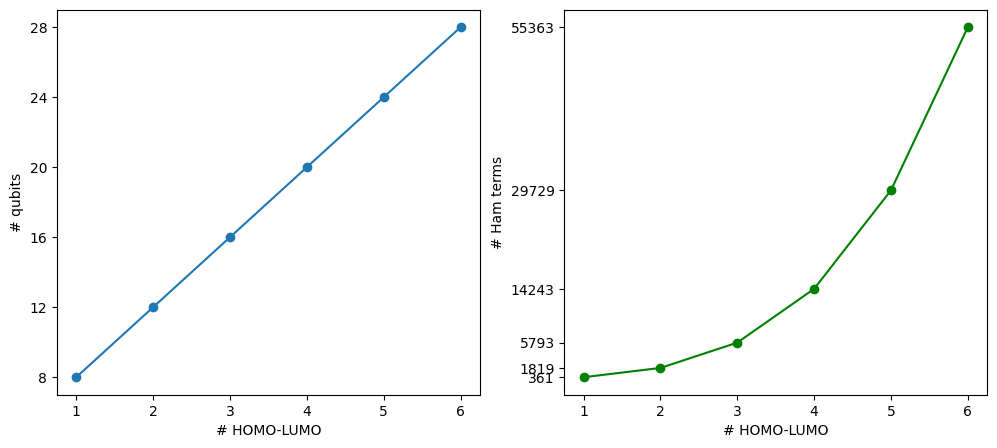

In [18]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(range(1,max_level), qubit_reqs, marker='o')
ax[0].set_xlabel('# HOMO-LUMO')
ax[0].set_ylabel('# qubits')
ax[0].set_xticks(range(1,max_level))
ax[0].set_yticks(qubit_reqs)

ax[1].plot(range(1,max_level), num_terms, marker='o', color='green')
ax[1].set_xlabel('# HOMO-LUMO')
ax[1].set_ylabel('# Ham terms')
ax[1].set_xticks(range(1,max_level))
ax[1].set_yticks(num_terms);

In [14]:
%%time
qu_op = fermion_to_qubit_mapping(frozen_mol.fermionic_hamiltonian, mapping="JW", 
                                 n_spinorbitals=frozen_mol.n_active_sos, n_electrons=frozen_mol.n_active_electrons, 
                                 spin=frozen_mol.spin, up_then_down=False)
n_qubits = count_qubits(qu_op)

CPU times: user 1min 43s, sys: 12.1 s, total: 1min 55s
Wall time: 14.4 s


## Qubit Tapering

Before we apply CS-VQE, one might as well perform qubit tapering since it does not introduce any systematic error. The number of qubits is reduced to 14 from 16. However, the number of hamiltonian terms are unaffected which can cause large measurement overhead. 

In [49]:
from symmer import PauliwordOp
from symmer.projection import ContextualSubspace
from symmer.utils import exact_gs_energy
from symmer.projection import QubitTapering
import pennylane as qml
from symmer.operators import IndependentOp

In [50]:
# convert openfermion to symmer ham
coeffs = []
term_list = []

for term, coeff in qu_op.terms.items():
    coeffs.append(coeff.real)
    pauli_string = ['I']*n_qubits
    for i, p in term:
        pauli_string[i] = p
    pauli_string = ''.join(pauli_string)
    term_list.append(pauli_string)
    
H_q = PauliwordOp.from_list(term_list, coeffs)
H_q.n_terms, H_q.n_qubits

(5785, 16)

In [51]:
IndependentOp.symmetry_generators(H_q, commuting_override=True)

1 ZIZIZIZIZIZIZIZI 
1 IZIZIZIZIZIZIZIZ

In [52]:
taper_hamiltonian = QubitTapering(H_q)
taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis()

-1 IXIIIIIIIIIIIIII 
-1 XIIIIIIIIIIIIIII

In order to perform the stabilizer subspace projection, we must also supply a symmetry sector or reference state.

In [53]:
hf_array = qml.qchem.hf_state(frozen_mol.n_active_electrons, frozen_mol.n_active_sos)
hf_array

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [54]:
taper_hamiltonian.stabilizers.update_sector(hf_array)
print(f'The symmetry sector corresponding with the reference state is {taper_hamiltonian.stabilizers.coeff_vec}')

The symmetry sector corresponding with the reference state is [1. 1.]


In [55]:
ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)

In [56]:
n_qubits_tapered = ham_tap.n_qubits

print(f"Number of qubits: {n_qubits}")
print(f"Number of qubits after tapering: {n_qubits_tapered}")

print(f"Number of terms: {H_q.n_terms}")
print(f"Number of terms after tapering: {ham_tap.n_terms}")

print(f"{n_qubits - n_qubits_tapered} Z2 symmetries detected")

Number of qubits: 16
Number of qubits after tapering: 14
Number of terms: 5785
Number of terms after tapering: 5785
2 Z2 symmetries detected


## Contextual Subspace Projection

This involves partitioning $H$ into noncontextual and contextual componenents satisfying $H = H_{contextual} + H_{noncon}$

In [77]:
hams = {}
for q in range(8, 1, -1):

    start = time()
    cs_vqe = ContextualSubspace(ham_tap, 
                        noncontextual_strategy='StabilizeFirst', 
                        noncontextual_solver='binary_relaxation',
                        unitary_partitioning_method='LCU')

    # Quantum Corrections
    cs_vqe.update_stabilizers(n_qubits = q)
    H_cs = cs_vqe.project_onto_subspace()

    print(f"num qubits: {q}, Duration: {time()- start}")
    
    try:
        # Hartree-Fock in contextual subspace
        hf_cs = cs_vqe.project_state_onto_subspace(taper_hamiltonian.tapered_ref_state) # Hartree-Fock in contextual subspace
        hf_cs_dict = hf_cs.to_dictionary.copy()
    except Exception as e:
        print(e)
        hf_cs_dict = {}

    # Saving the contextual hamiltonian and hartree fock state
    hams[q] = {
        'ham': H_cs.to_dictionary.copy(),
        'hf': hf_cs_dict.copy()
    }

    with open('CS_hams.pickle', 'wb') as handle:
        pickle.dump(hams, handle, protocol=pickle.HIGHEST_PROTOCOL)

    del cs_vqe

num qubits: 8, Duration: 102.49231457710266
num qubits: 7, Duration: 83.7322165966034
num qubits: 6, Duration: 93.59304094314575
reduce() of empty sequence with no initial value
num qubits: 5, Duration: 99.05808568000793
reduce() of empty sequence with no initial value
num qubits: 4, Duration: 93.18911576271057
reduce() of empty sequence with no initial value
num qubits: 3, Duration: 84.51380729675293
reduce() of empty sequence with no initial value
num qubits: 2, Duration: 94.33418846130371
reduce() of empty sequence with no initial value


## What's next?

We can now perform a VQE simulation over these Contextual Hamiltonians which will yield the quantum-corrected energy.